# Generative Adversarial Networks

## Introduction

* Uses two networks competing against each other to generate data.

* They're described as a counterfeiter versus a detective.

## Working

### Generator (Counterfeiter)

* Receives random noise (Gaussian distribution).

* Outputs data (often an image).

* Its goal is to create images that fool the discriminator.

* It keeps improving the images it outputs so as to fool the discriminator better.

### Discriminator (Detective)

* Takes a data set consisting of real images from the real data set and fake images from the generator.

* Attempts to classift real vs fake images (it is always a binary classification).

## Phases

### Phase 1: Train Discriminator

* Real images (labeled 1) are combined with fake images from generator (labeled 0).

* Discriminator trains to distinguish real from fake.

**Here, backpropagation only happens on discriminator weights.**

### Phase 2: Train Generator

* Produce fake images with generator.

* Feed only these fake images to the generator with all labels set as real (1).

* This causes the generator to attempt to produce images the discriminator believes to be real.

* The generator never gets to see the actual real images, it only generates convincing images based off of       gradient flowing back through the discriminator.

**Here, backpropagation only happens on generator weights.**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filtering out Data

* For checking the performance of GAN in a faster way.

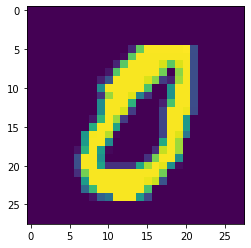

In [4]:
only_zeros = X_train[y_train==0]
plt.imshow(only_zeros[10])

# Creating Discriminator

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

In [6]:
discriminator = Sequential()

discriminator.add(Flatten(input_shape=[28, 28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))

discriminator.add(Dense(1, activation='sigmoid')) # Last layer will always remain the same

discriminator.compile('adam', 'binary_crossentropy')

# Creating Generator

* Its structure is a lot like a decoder.

In [7]:
codings_size = 100 # Must be lesser than 784, but not too less

generator = Sequential()

generator.add(Dense(100, activation='relu', input_shape=[codings_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation='relu'))
generator.add(Reshape([28, 28]))

# Creating GAN

In [8]:
GAN = Sequential([generator, discriminator])

discriminator.trainable = False # The discriminator should not be trained during the second phase

GAN.compile('adam', 'binary_crossentropy')

In [9]:
GAN.layers[0].summary() # Corresponds to Discriminator

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [10]:
GAN.layers[1].summary() # Corresponds to Generator

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


# Setting up Training Slices

In [11]:
batch_size = 30

In [12]:
# Similar to my_data = X_train
my_data = only_zeros

In [13]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [14]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [15]:
epochs = 1

In [16]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
    
    print(f'Currently on epoch {epoch + 1}...')

    i = 0
    
    for X_batch in dataset:
        
        i = i + 1
        
        if i % 100 == 0:
            print(f'\t Currently on batch number {i} of {len(my_data) // batch_size}')
            
        # Discriminator Phase
        
        noise = tf.random.normal(shape=[batch_size, codings_size])

        gen_images = generator(noise)
        
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
        
        y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
        
        discriminator.trainable = True
        
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        # Generator phase
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        y2 = tf.constant([[1.0]] * batch_size)
        
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)

Currently on epoch 1...
	 Currently on batch number 100 of 197


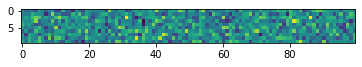

In [19]:
noise = tf.random.normal(shape=[10, codings_size])

plt.imshow(noise)

In [20]:
images = generator(noise)
images.shape

TensorShape([10, 28, 28])

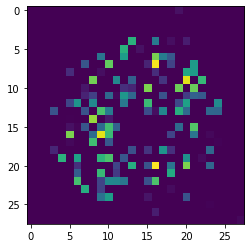

In [24]:
plt.imshow(images[0])

# Model Collapse...

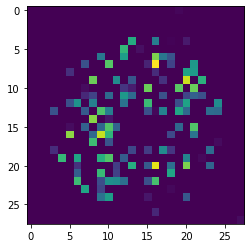

In [25]:
plt.imshow(images[8])